In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import  ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint, CSVLogger
from tensorflow.keras.losses import categorical_crossentropy as logloss
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import opendatasets as od
from tensorflow.keras.utils import plot_model

In [ ]:
#upload the data into colab

od.download("https://www.kaggle.com/datasets/itamargr/dfdc-faces-of-the-train-sample")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mustafaarahim
Your Kaggle Key: ··········


100%|██████████| 3.64G/3.64G [00:41<00:00, 93.7MB/s]


In [ ]:
ig = ImageDataGenerator(rescale=1./255.)
train_flow = ig.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/train',
    target_size=(160, 160),
    batch_size=100,
    class_mode='categorical',

)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/validation',
    target_size=(160, 160),
    batch_size=100,
    class_mode='categorical',

)

test_flow = ig.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/validation',
    target_size=(160, 160),
    batch_size=100,
    shuffle = False,
    class_mode='categorical',
)

train_flow.class_indices

Found 93853 images belonging to 2 classes.
Found 30794 images belonging to 2 classes.
Found 30794 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [ ]:
def build_model():
    densenet = ResNet50V2(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(160,160,3)
                        )
    model = Sequential([densenet,

                        layers.GlobalAveragePooling2D(),
                        layers.Dense(1024, activation = 'relu'),
                        layers.BatchNormalization(),
                         layers.Dense(256, activation = 'relu'),
                        layers.BatchNormalization(),


                        layers.Dense(2, activation='softmax')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [ ]:
model=build_model()
model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                         

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=1,
                              verbose=1,
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
history = model.fit(train_flow,
    epochs = 5,
    validation_data =valid_flow,
    callbacks=callbacks
)

Epoch 1/5
939/939 [==============================] - ETA: 0s - loss: 0.1793 - accuracy: 0.9345
Epoch 1: val_loss improved from inf to 1.07892, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


939/939 [==============================] - 580s 568ms/step - loss: 0.1793 - accuracy: 0.9345 - val_loss: 1.0789 - val_accuracy: 0.7735 - lr: 0.0010
Epoch 2/5
939/939 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9707
Epoch 2: val_loss improved from 1.07892 to 0.38674, saving model to model.h5
939/939 [==============================] - 520s 554ms/step - loss: 0.0747 - accuracy: 0.9707 - val_loss: 0.3867 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 3/5
939/939 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9751
Epoch 3: val_loss did not improve from 0.38674

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
939/939 [==============================] - 508s 541ms/step - loss: 0.0640 - accuracy: 0.9751 - val_loss: 0.5267 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 4/5
939/939 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9859
Epoch 4: val_loss did not improve from 0.38674

Epoch 4: ReduceLROnPl

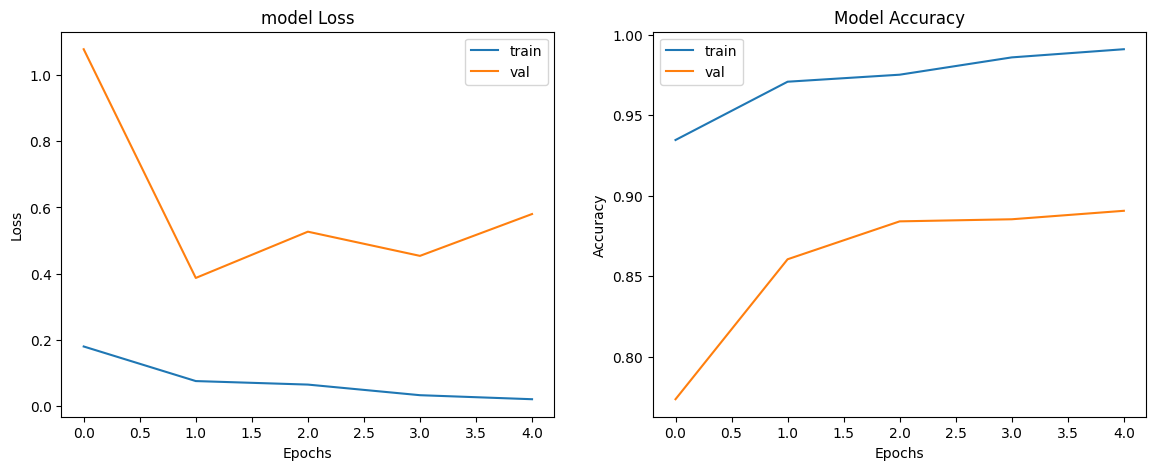

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.show()

In [ ]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

308/308 [==============================] - 62s 196ms/step


In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
confusion_matrix=confusion_matrix(y_test, y_pred_labels)
confusion_matrix

array([[22805,  1960],
       [ 1410,  4619]])

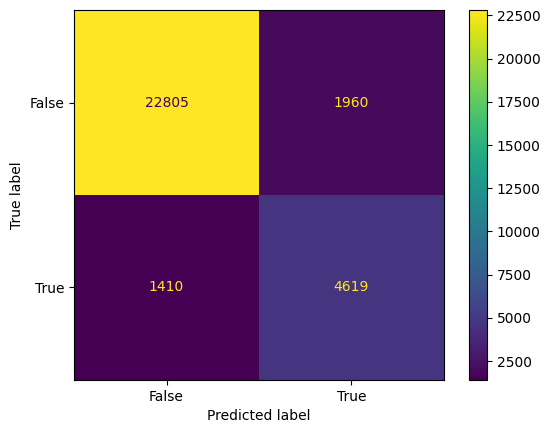

In [ ]:
Fake=False
Real=True

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [Fake, Real])

cm_display.plot()
plt.show()

In [ ]:
_, accu = model.evaluate(test_flow)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

308/308 [==============================] - 64s 209ms/step - loss: 0.5802 - accuracy: 0.8906
Final Test Acccuracy = 89.056


In [ ]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_labels))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_labels))
print()
print(metrics.classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.8434932083596087
AP Score: 0.5836747765813217

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     24765
           1       0.70      0.77      0.73      6029

    accuracy                           0.89     30794
   macro avg       0.82      0.84      0.83     30794
weighted avg       0.89      0.89      0.89     30794



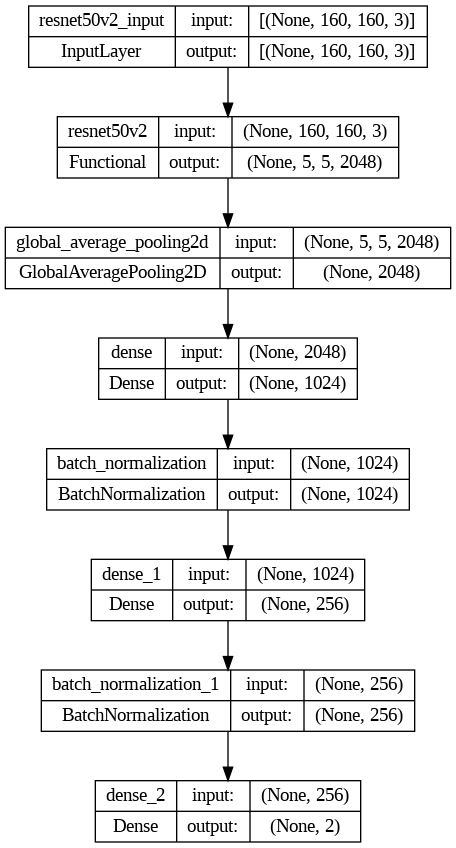

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)